In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part#1 Install & Import Libraries

In [ ]:
!pip install tensorflow==2.17.1
!pip install dlib
!pip install face_recognition --no-cache-dir
!pip install imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.17.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.17.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 205.6 MB/s eta 0:00:00
  Preparing metadata (s

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
# Part 2: Imports
# -*- coding: utf-8 -*-
import random
import os
import numpy as np
from math import floor
from scipy.ndimage import zoom, rotate
from os.path import join, isfile
from os import listdir, makedirs
import imageio
import face_recognition
#
import requests
from typing import Dict, List, Tuple
import time

#Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Keras imports
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.models import Model as KerasModel
from keras._tf_keras.keras.layers import (
    Input, Dense, Flatten, Conv2D, Conv3D,
    MaxPooling2D, MaxPooling3D, BatchNormalization,
    Dropout, Concatenate, LeakyReLU, Average,
    TimeDistributed, GlobalAveragePooling3D)
from keras._tf_keras.keras.optimizers import AdamW
from keras._tf_keras.keras.regularizers import l2
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from keras._tf_keras.keras.utils import Sequence

# Part#2 Global Variables

In [ ]:
# Part3: Constant Value
IMGWIDTH = 256         # Image Size
FRAME_COUNT = 10       # Number of frames for 3D processing
WEIGHT_DECAY = 1e-5    # AdamW optimizer decaying weight
Batches_Size = 64      # Number of batches #Bathes_Size
Epoch_Size = 60       # Number of epochs

# Part#3 Face Extraction Pipline

In [ ]:
# Force every face_locations call to use the CPU HOG detector

_orig_face_locations = face_recognition.face_locations

def face_locations_hog(image, number_of_times_to_upsample=1, model='hog'):
    """
    Ignore whatever model was requested and always use HOG.
    """
    return _orig_face_locations(image,
                                number_of_times_to_upsample,
                                model='hog')

# Monkey-patch both the public and internal entry points
face_recognition.face_locations          = face_locations_hog
face_recognition.api.face_locations      = face_locations_hog


In [ ]:
# Part 4: Pipeline (Video Processing and Face Detection)
class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']

    def init_head(self):
        self.container.set_image_index(0)

    def next_frame(self):
        self.container.get_next_data()

    def get(self, key):
        return self.container.get_data(key)

    def __call__(self, key):
        return self.get(key)

    def __len__(self):
        return self.length

class FaceFinder(Video):
    def __init__(self, path, load_first_face=True):
        super().__init__(path)
        self.faces = {}
        self.coordinates = {}
        self.last_frame = self.get(0)
        self.frame_shape = self.last_frame.shape[:2]
        self.last_location = (0, 200, 200, 0)
        if load_first_face:
            face_positions = face_recognition.face_locations(self.last_frame, number_of_times_to_upsample=2)
            if len(face_positions) > 0:
                self.last_location = face_positions[0]

    def load_coordinates(self, filename):
        np_coords = np.load(filename)
        self.coordinates = np_coords.item()

    def expand_location_zone(self, loc, margin=0.2):
        ''' Adds a margin around a frame slice '''
        offset = round(margin * (loc[2] - loc[0]))
        y0 = max(loc[0] - offset, 0)
        x1 = min(loc[1] + offset, self.frame_shape[1])
        y1 = min(loc[2] + offset, self.frame_shape[0])
        x0 = max(loc[3] - offset, 0)
        return (y0, x1, y1, x0)

    @staticmethod
    def upsample_location(reduced_location, upsampled_origin, factor):
        ''' Adapt a location to an upsampled image slice '''
        y0, x1, y1, x0 = reduced_location
        Y0 = round(upsampled_origin[0] + y0 * factor)
        X1 = round(upsampled_origin[1] + x1 * factor)
        Y1 = round(upsampled_origin[0] + y1 * factor)
        X0 = round(upsampled_origin[1] + x0 * factor)
        return (Y0, X1, Y1, X0)

    @staticmethod
    def pop_largest_location(location_list):
        max_location = location_list[0]
        max_size = 0
        if len(location_list) > 1:
            for location in location_list:
                size = location[2] - location[0]
                if size > max_size:
                    max_size = size
                    max_location = location
        return max_location

    @staticmethod
    def L2(A, B):
        return np.sqrt(np.sum(np.square(A - B)))

    def find_coordinates(self, landmark, K=2.2):
        '''
        We either choose K * distance(eyes, mouth),
        or, if the head is tilted, K * distance(eye 1, eye 2)
        /! landmarks coordinates are in (x,y) not (y,x)
        '''
        E1 = np.mean(landmark['left_eye'], axis=0)
        E2 = np.mean(landmark['right_eye'], axis=0)
        E = (E1 + E2) / 2
        N = np.mean(landmark['nose_tip'], axis=0) / 2 + np.mean(landmark['nose_bridge'], axis=0) / 2
        B1 = np.mean(landmark['top_lip'], axis=0)
        B2 = np.mean(landmark['bottom_lip'], axis=0)
        B = (B1 + B2) / 2

        C = N
        l1 = self.L2(E1, E2)
        l2 = self.L2(B, E)
        l = max(l1, l2) * K
        if (B[1] == E[1]):
            if (B[0] > E[0]):
                rot = 90
            else:
                rot = -90
        else:
            rot = np.arctan((B[0] - E[0]) / (B[1] - E[1])) / np.pi * 180

        return ((floor(C[1]), floor(C[0])), floor(l), rot)

    def find_faces(self, resize=0.5, stop=0, skipstep=0, no_face_acceleration_threshold=3, cut_left=0, cut_right=-1, use_frameset=False, frameset=[]):
        '''
        The core function to extract faces from frames
        using previous frame location and downsampling to accelerate the loop.
        '''
        not_found = 0
        no_face = 0
        no_face_acc = 0

        # to only deal with a subset of a video, for instance I-frames only
        if (use_frameset):
            finder_frameset = frameset
        else:
            if stop != 0:
                finder_frameset = range(0, min(self.length, stop), skipstep + 1)
            else:
                finder_frameset = range(0, self.length, skipstep + 1)

        # Quick face finder loop
        for i in finder_frameset:
            # Get frame
            frame = self.get(i)
            if (cut_left != 0 or cut_right != -1):
                frame[:, :cut_left] = 0
                frame[:, cut_right:] = 0

            # Find face in the previously found zone
            potential_location = self.expand_location_zone(self.last_location)
            potential_face_patch = frame[potential_location[0]:potential_location[2], potential_location[3]:potential_location[1]]
            potential_face_patch_origin = (potential_location[0], potential_location[3])

            reduced_potential_face_patch = zoom(potential_face_patch, (resize, resize, 1))
            reduced_face_locations = face_recognition.face_locations(reduced_potential_face_patch, model = 'cnn')

            if len(reduced_face_locations) > 0:
                no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                reduced_face_location = self.pop_largest_location(reduced_face_locations)
                face_location = self.upsample_location(reduced_face_location,
                                                    potential_face_patch_origin,
                                                    1 / resize)
                self.faces[i] = face_location
                self.last_location = face_location

                # extract face rotation, length and center from landmarks
                landmarks = face_recognition.face_landmarks(frame, [face_location])
                if len(landmarks) > 0:
                    # we assume that there is one and only one landmark group
                    self.coordinates[i] = self.find_coordinates(landmarks[0])
            else:
                not_found += 1

                if no_face_acc < no_face_acceleration_threshold:
                    # Look for face in full frame
                    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample = 2)
                else:
                    # Avoid spending to much time on a long scene without faces
                    reduced_frame = zoom(frame, (resize, resize, 1))
                    face_locations = face_recognition.face_locations(reduced_frame)

                if len(face_locations) > 0:
                    print('Face extraction warning : ', i, '- found face in full frame', face_locations)
                    no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                    face_location = self.pop_largest_location(face_locations)

                    # if was found on a reduced frame, upsample location
                    if no_face_acc > no_face_acceleration_threshold:
                        face_location = self.upsample_location(face_location, (0, 0), 1 / resize)

                    self.faces[i] = face_location
                    self.last_location = face_location

                    # extract face rotation, length and center from landmarks
                    landmarks = face_recognition.face_landmarks(frame, [face_location])
                    if len(landmarks) > 0:
                        self.coordinates[i] = self.find_coordinates(landmarks[0])
                else:
                    print('Face extraction warning : ',i, '- no face')
                    no_face_acc += 1
                    no_face += 1

        # *Added New*
        if not_found == 0 and no_face == 0:
            print('Face extraction report of', 'not_found :', not_found , ',No missing data - Success!')
            print('Face extraction report of', 'no_face :', no_face, ',At least one face detected - Success!\n')
        else:
            print('Face extraction report of', 'not_found :', not_found , ',Some of the data is/are missed!!\n')
            print("Face extraction report of", "no_face :", no_face, ",Couldn't detect a face!!")

        return 0

    def get_face(self, i):
        ''' Basic unused face extraction without alignment '''
        frame = self.get(i)
        if i in self.faces:
            loc = self.faces[i]
            patch = frame[loc[0]:loc[2], loc[3]:loc[1]]
            return patch
        return frame

    @staticmethod
    def get_image_slice(img, y0, y1, x0, x1):
        '''Get values outside the domain of an image'''
        m, n = img.shape[:2]
        padding = max(-y0, y1-m, -x0, x1-n, 0)
        padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
        return padded_img[(padding + y0):(padding + y1),
                        (padding + x0):(padding + x1)]

    def get_aligned_face(self, i, l_factor = 1.3):
        '''
        The second core function that converts the data from self.coordinates into an face image.
        '''
        frame = self.get(i)
        if i in self.coordinates:
            c, l, r = self.coordinates[i]
            l = int(l) * l_factor # fine-tuning the face zoom we really want
            dl_ = floor(np.sqrt(2) * l / 2) # largest zone even when rotated
            patch = self.get_image_slice(frame,
                                    floor(c[0] - dl_),
                                    floor(c[0] + dl_),
                                    floor(c[1] - dl_),
                                    floor(c[1] + dl_))
            rotated_patch = rotate(patch, -r, reshape=False)
            # note : dl_ is the center of the patch of length 2dl_
            return self.get_image_slice(rotated_patch,
                                    floor(dl_-l//2),
                                    floor(dl_+l//2),
                                    floor(dl_-l//2),
                                    floor(dl_+l//2))
        return frame

class FaceBatchGenerator:
    def __init__(self, face_finder, target_size = 256):
        self.finder = face_finder
        self.target_size = target_size
        self.head = 0
        self.length = int(face_finder.length)

    def resize_patch(self, patch):
        m, n = patch.shape[:2]
        return zoom(patch, (self.target_size / m, self.target_size / n, 1))

    def next_batch(self, batch_size = 50):
        batch = np.zeros((1, self.target_size, self.target_size, 3))
        stop = min(self.head + batch_size, self.length)
        i = 0
        while (i < batch_size) and (self.head < self.length):
            if self.head in self.finder.coordinates:
                patch = self.finder.get_aligned_face(self.head)
                batch = np.concatenate((batch, np.expand_dims(self.resize_patch(patch), axis = 0)),
                                        axis = 0)
                i += 1
            self.head += 1
        return batch[1:]

def predict_faces(generator, classifier, batch_size = 50, output_size = 1):
    n = len(generator.finder.coordinates.items())
    profile = np.zeros((1, output_size))
    for epoch in range(n // batch_size + 1):
        face_batch = generator.next_batch(batch_size = batch_size)
        prediction = classifier.predict(face_batch)
        if (len(prediction) > 0):
            profile = np.concatenate((profile, prediction))
    return profile[1:]

def compute_accuracy(classifier, dirname, frame_subsample_count = 30):
    '''
    Extraction + Prediction over a video

    Note to me:
    1. Processes all videos in a directory.
    2. Extracts faces and makes predictions.
    3. Computes the average classification accuracy for each video.
    '''
    filenames = [f for f in listdir(dirname) if isfile(join(dirname, f)) and ((f[-4:] == '.mp4') or (f[-4:] == '.avi') or (f[-4:] == '.mov'))]
    predictions = {}

    for vid in filenames:
        print('Dealing with video ', vid)

        # Compute face locations and store them in the face finder
        face_finder = FaceFinder(join(dirname, vid), load_first_face = False)
        skipstep = max(floor(face_finder.length / frame_subsample_count), 0)
        face_finder.find_faces(resize=0.5, skipstep = skipstep)

        print('Predicting ', vid)
        gen = FaceBatchGenerator(face_finder)
        p = predict_faces(gen, classifier)

        predictions[vid[:-4]] = (np.mean(p > 0.5), p)
    return predictions

# Part#4 Classifiers (Updated Models)

In [ ]:
# Part 5: Classification Models
class Classifier:
    def __init__(self):
        self.model = None

    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)


# Updated Meso4 with AdamW optimization (insted of Adam) and binary_crossentropy as the loss function (instead of MSE)
class Meso4(Classifier):
    """2D CNN with AdamW optimization"""
    def __init__(self, learning_rate = 0.001, weights_path = None):
        self.model = self.init_model()
        optimizer = AdamW(learning_rate = learning_rate, weight_decay = WEIGHT_DECAY)
        self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        if weights_path:
            self.load(weights_path)

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16, kernel_regularizer=l2(WEIGHT_DECAY))(y)
        y = LeakyReLU(negative_slope=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

# Updated MesoInception4 with AdamW optimization (insted of Adam) and binary_crossentropy as the loss function (instead of MSE)
class MesoInception4(Classifier):
    """Inception-style model with multi-scale feature extraction"""
    def __init__(self, learning_rate = 0.001, weights_path = None):
        self.model = self.init_model()
        optimizer = AdamW(learning_rate = learning_rate, weight_decay = WEIGHT_DECAY)
        self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        if weights_path:
            self.load(weights_path)

    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)

            x2 = Conv2D(b, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x2)

            x3 = Conv2D(c, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)
            x3 = Conv2D(c, (3, 3), dilation_rate=2, padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x3)

            x4 = Conv2D(d, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)
            x4 = Conv2D(d, (3, 3), dilation_rate=3, padding='same', activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x4)

            y = Concatenate(axis=-1)([x1, x2, x3, x4])
            return y
        return func

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(negative_slope=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


                   ##### New added Models Meso3D (with training) and DeepfakeEnsemble #######
class Meso3D(Classifier):
    """3D CNN for temporal analysis with AdamW."""
    def __init__(self, learning_rate=1e-3, weights_path=None):
        self.model = self._init_model()
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=WEIGHT_DECAY
        )
        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        if weights_path:
            self.model.load_weights(weights_path)

    def _init_model(self):
        inp = Input(shape=(FRAME_COUNT, IMGWIDTH, IMGWIDTH, 3))

        # 2D conv per frame
        x = TimeDistributed(Conv2D(16, (3,3),
                                   padding='same',
                                   activation='relu',
                                   kernel_regularizer=l2(WEIGHT_DECAY)
                                  ))(inp)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling2D((2,2)))(x)

        # 3D conv blocks
        x = Conv3D(32, (3,3,3),
                   padding='same',
                   activation='relu',
                   kernel_regularizer=l2(WEIGHT_DECAY)
                  )(x)
        x = BatchNormalization()(x)
        x = MaxPooling3D((2,2,2))(x)

        x = Conv3D(64, (3,3,3),
                   padding='same',
                   activation='relu',
                   kernel_regularizer=l2(WEIGHT_DECAY)
                  )(x)
        x = BatchNormalization()(x)
        x = MaxPooling3D((2,2,2))(x)

        x = Conv3D(128, (3,3,3),
                   padding='same',
                   activation='relu',
                   kernel_regularizer=l2(WEIGHT_DECAY)
                  )(x)
        x = BatchNormalization()(x)
        x = GlobalAveragePooling3D()(x)

        # classification head
        y = Dense(128,
                  kernel_regularizer=l2(WEIGHT_DECAY))(x)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        out = Dense(1, activation='sigmoid')(y)

        return KerasModel(inputs=inp, outputs=out)

class DeepfakeEnsemble(Classifier):
    """Enhanced ensemble model combining Meso4, MesoInception4 (images) and Meso3D (videos)"""
    def __init__(self, weights_dir='weights'):
        self.models = {
            'meso4': Meso4(weights_path=os.path.join(weights_dir, 'Meso4_DF.h5')),
            'meso_inception': MesoInception4(weights_path=os.path.join(weights_dir, 'MesoInception_DF.h5')),
            'meso3d': Meso3D(weights_path=os.path.join(weights_dir, 'Meso3D.h5'))
        }

        # Verify which models actually loaded successfully
        self.available_models = {name: model for name, model in self.models.items() if model.model is not None}
        if not self.available_models:
            raise ValueError("Failed to load any models for the ensemble.")

    def predict(self, x, verbose=False):
        """Make binary prediction using ensemble of models"""
        predictions = []
        total_weight = 0
        final_prediction = 0

        for model_name, model in self.available_models.items():
            try:
                pred = model.predict(x)[0][0]
                weight = 1.0  # You can assign different weights if needed

                predictions.append({
                    'model': model_name,
                    'prediction': pred,
                    'label': 'Fake' if pred > 0.5 else 'Real',
                    'confidence': pred if pred > 0.5 else 1 - pred
                })

                final_prediction += pred * weight
                total_weight += weight

            except Exception as e:
                print(f"Warning: {model_name} failed with the error {str(e)}")
                continue

        if total_weight > 0:
            final_prediction /= total_weight
            final_label = 'Fake' if final_prediction > 0.5 else 'Real'
            final_confidence = final_prediction if final_prediction > 0.5 else 1 - final_prediction

            ensemble_result = {
                'ensemble': {
                    'prediction': float(final_prediction),
                    'label': final_label,
                    'confidence': float(final_confidence)
                }
            }

            if verbose:
                self._print_results(predictions, ensemble_result)

            return {
                'individual': predictions,
                'ensemble': ensemble_result,
                'accuracy': None
            }
        else:
            raise RuntimeError("No valid model predictions could be made.")

# Part#5: Training Related Functions / Utilities

In [ ]:
#1. Custome callback to print accuracy and loss
class TrainingLog(Callback):
    def __init__(self, wd_decay_factor=0.5, wd_decay_every=5):
        super().__init__()
        self.lr_history = []
        self.wd_history = []
        self.wd_decay_factor = wd_decay_factor
        self.wd_decay_every = wd_decay_every
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nStarting Epoch {epoch + 1}...")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_time = time.time() - self.epoch_start_time

        #Tracing Learning Rate
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lr_history.append(lr)

        #Track Weight Decaying
        wd_val = 0.0
        wd = getattr(self.model.optimizer, 'weight_decay', None)

        if wd is not None:
            wd_val = float(tf.keras.backend.get_value(wd))

            # decay every N epochs, skipping epoch 0
            if epoch and epoch % self.wd_decay_every == 0:
                new_wd = wd_val * self.wd_decay_factor
                wd_obj = self.model.optimizer.weight_decay   # ← alias is OK
                if hasattr(wd_obj, "assign"):                # tf.Variable case
                    wd_obj.assign(new_wd)
                else:                                        # plain float
                    self.model.optimizer.weight_decay = new_wd

                wd_val = new_wd          # log the value actually in use

        # one—and only one—append per epoch
        self.wd_history.append(wd_val)


        print(f"\n Epoch {epoch + 1} completed in {epoch_time:.2f} seconds")
        print(f"    Loss: {logs.get('loss'):.4f} - Accuracy: {logs.get('accuracy'):.4f}")
        print(f"    Eval Loss: {logs.get('val_loss'):.4f} - Eval Accuracy: {logs.get('val_accuracy'):.4f}")
        print(f"    Learning Rate: {lr:.6f} - Decaying weight: {wd_val:.6f}")

In [ ]:
def plotting_metrics(history, *,
                     true_labels=None, predictions=None, prediction_prob=None,
                     class_names=None, learning_rate=None, weight_decay=None):
    """
    Six-panel performance dashboard.
    """
    fig, axs = plt.subplots(3, 2, figsize=(16, 14))
    fig.tight_layout(pad=4.0)

    # 1) Confusion matrix --------------------------------------
    if true_labels is not None and predictions is not None:
        cm = confusion_matrix(true_labels, predictions)
        ConfusionMatrixDisplay(cm, display_labels=class_names).plot(
            ax=axs[0, 0], colorbar=False)
        axs[0, 0].set_title("Confusion Matrix")
    else:
        axs[0, 0].axis('off')

    # 2) Loss curves -------------------------------------------
    axs[0, 1].plot(history.history['loss'],     label='Train', color='red')
    axs[0, 1].plot(history.history['val_loss'], label='Val',   color='green')
    axs[0, 1].set_title("Training vs. Validation Loss")
    axs[0, 1].set_xlabel("Epoch"); axs[0, 1].set_ylabel("loss"); axs[0, 1].legend()

    # 3) Accuracy curves ---------------------------------------
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        axs[1, 0].plot(history.history['accuracy'],     label='Train', color='blue')
        axs[1, 0].plot(history.history['val_accuracy'], label='Val',   color='orange')
        axs[1, 0].set_title("Accuracy Curve")
        axs[1, 0].set_xlabel("Epoch"); axs[1, 0].set_ylabel("Accuracy"); axs[1, 0].legend()
    else:
        axs[1, 0].axis('off')

    # 4) Accuracy vs Loss --------------------------------------
    acc  = history.history.get('val_accuracy') or history.history.get('accuracy')
    loss = history.history.get('val_loss')     or history.history.get('loss')
    if acc and loss:
        axs[1, 1].plot(acc, loss, 'o--', color='purple')
        axs[1, 1].set_title("Accuracy vs. Loss")
        axs[1, 1].set_xlabel("Accuracy"); axs[1, 1].set_ylabel("Loss")
    else:
        axs[1, 1].axis('off')

    # 5) WD vs LR ----------------------------------------------
    if learning_rate is not None and weight_decay is not None:
        axs[2, 0].plot(learning_rate, weight_decay, 'x-')
        axs[2, 0].set_title("Weight-Decay vs. Learning-Rate")
        axs[2, 0].set_xlabel("LR"); axs[2, 0].set_ylabel("WD")
    else:
        axs[2, 0].axis('off')

    # 6) ROC curve ---------------------------------------------
    if true_labels is not None and prediction_prob is not None:
        fpr, tpr, _ = roc_curve(true_labels, prediction_prob)
        roc_auc = auc(fpr, tpr)
        axs[2, 1].plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
        axs[2, 1].plot([0, 1], [0, 1], '--', color='gray')
        axs[2, 1].set_title("ROC Curve")
        axs[2, 1].set_xlabel("FPR"); axs[2, 1].set_ylabel("TPR")
        axs[2, 1].legend()
    else:
        axs[2, 1].axis('off')

    plt.suptitle("Training Performance Overview", fontsize=16)
    plt.show()

In [ ]:
import tensorflow as tf


def set_global_seed(seed: int = 42) -> None:
    """
    Fix Python-level, NumPy-level and TensorFlow-level RNGs so that
    every run is bit-for-bit reproducible (assuming single-GPU).
    Call it once at the very top of the training function.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)   # Python
    random.seed(seed)                          # random
    np.random.seed(seed)                       # NumPy
    tf.random.set_seed(seed)                   # TF / Keras



#  training wrapper
def train_and_visualize_big(
        ModelClass,
        train_dir,
        val_dir,
        epochs           = 20,
        batch_size       = 32,
        lr               = 1e-3,
        use_augmentation = True,
        checkpoint_file  = 'best_model.weights.h5',
        wd_decay_factor  = 0.5,
        wd_decay_every   = 5,
        seed             = 42,          # ➊ new
):
    # ---- A) reproducibility --------------------------------------
    set_global_seed(seed)               # ➋ new

    # ---- B) instantiate model ------------------------------------
    model_wrapper = ModelClass(learning_rate=lr)
    model         = model_wrapper.model

    # ---- C) data generators --------------------------------------
    g_args = dict(target_size=(256, 256),
                  batch_size=batch_size,
                  class_mode='binary',
                  seed=seed)            # ➌ new

    if use_augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255, rotation_range=15, zoom_range=0.2,
            brightness_range=(0.8, 1.2), channel_shift_range=30,
            horizontal_flip=True)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(train_dir, **g_args)
    val_gen   = ImageDataGenerator(rescale=1./255)\
                   .flow_from_directory(val_dir, shuffle=False, **g_args)

    # ---- D) callbacks --------------------------------------------
    checkpoint = ModelCheckpoint(
        checkpoint_file, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=True, verbose=1)
    lr_sched   = ReduceLROnPlateau(
        monitor='val_accuracy', mode='max', factor=0.5,
        patience=5, verbose=1, min_lr=1e-6)
    log_cb     = TrainingLog(wd_decay_factor=wd_decay_factor,
                             wd_decay_every=wd_decay_every)

    # ---- E) train -------------------------------------------------
    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=val_gen,
                        callbacks=[checkpoint, lr_sched, log_cb])

    # ---- F) ALWAYS evaluate the best checkpoint ------------------
    model.load_weights(checkpoint_file)         # ➍ new ✅
    val_gen.reset()
    probas = model.predict(val_gen, verbose=0).ravel()
    preds  = (probas >= 0.5).astype(int)
    y_true = val_gen.classes
    class_names = list(val_gen.class_indices.keys())

    print("\nClassification report (threshold = 0.50)")
    print(classification_report(y_true, preds,
                                target_names=class_names, digits=3))

    plotting_metrics(history,
                     true_labels   = y_true,
                     predictions   = preds,
                     prediction_prob=probas,
                     class_names   = class_names,
                     learning_rate = log_cb.lr_history,
                     weight_decay  = log_cb.wd_history)

    best_val_acc = max(history.history['val_accuracy'])
    best_epoch   = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"\nBest epoch = {best_epoch} | best val_accuracy = {best_val_acc:.4f}")

    return model_wrapper, history, log_cb


In [ ]:
# ── Section 2: VideoFaceSequence with Caching ──────────────────────────────

class VideoFaceSequence(Sequence):
    def __init__(self,
                 video_paths,
                 labels,
                 batch_size,
                 target_size=IMGWIDTH,
                 cache_dir='preprocessed_sequences_Final',
                 shuffle=True,
                 verbose=False):
        self.video_paths = video_paths
        self.labels      = labels
        self.batch_size  = batch_size
        self.target_size = target_size
        self.shuffle     = shuffle
        self.verbose     = verbose
        self.indexes     = np.arange(len(video_paths))

        # on-disk cache
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        if self.verbose:
            print(f"[Sequence] Loading batch {idx}…")
        i0 = idx * self.batch_size
        i1 = min(i0 + self.batch_size, len(self.video_paths))
        batch_idxs = self.indexes[i0:i1]

        batch_x, batch_y = [], []
        for i in batch_idxs:
            vp   = self.video_paths[i]
            lbl  = self.labels[i]
            base = os.path.splitext(os.path.basename(vp))[0]
            npz  = os.path.join(self.cache_dir, f"{base}.npz")

            if os.path.exists(npz):
                arr = np.load(npz)['arr']
                if self.verbose:
                    print(f"  → loaded cache for {base}")
            else:
                ff   = FaceFinder(vp)
                ff.find_faces()
                fg   = FaceBatchGenerator(ff, target_size=self.target_size)
                try:
                    arr = fg.next_batch(batch_size=FRAME_COUNT)
                except:
                    arr = np.zeros((0, self.target_size, self.target_size, 3),
                                   dtype=np.float32)

                # pad to FRAME_COUNT
                if arr.shape[0] < FRAME_COUNT:
                    pad = np.zeros((FRAME_COUNT - arr.shape[0],
                                    self.target_size,
                                    self.target_size,
                                    3), dtype=np.float32)
                    arr = np.concatenate([arr, pad], axis=0)

                if arr.size == 0:
                    arr = np.zeros((FRAME_COUNT,
                                    self.target_size,
                                    self.target_size,
                                    3), dtype=np.float32)

                np.savez_compressed(npz, arr=arr)
                if self.verbose:
                    print(f"  → cached new sequence for {base}")

            batch_x.append(arr)
            batch_y.append(lbl)

        x = np.array(batch_x, dtype=np.float32) / 255.0
        y = np.array(batch_y, dtype=np.int32)
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def get_all_data(self):
        vs, ls = [], []
        for i in range(len(self)):
            x, y = self[i]
            vs.append(x);  ls.append(y)
        return np.concatenate(vs), np.concatenate(ls)

In [ ]:
# ── Section 3: Training Loop & Execution ───────────────────────────────────

def meso3D_train_model(video_train_paths,
                       train_labels,
                       eval_video_paths,
                       eval_labels,
                       batch_size,
                       epochs,
                       model_name='meso3d_V6_B16_E60_Lr1e-3_Final.weights.h5',
                       output_path='/content/drive/MyDrive/DL_Project/output/'):
    os.makedirs(output_path, exist_ok=True)

    tr_gen  = VideoFaceSequence(video_train_paths,
                                train_labels,
                                batch_size,
                                shuffle=True,
                                verbose=False)
    val_gen = VideoFaceSequence(eval_video_paths,
                                eval_labels,
                                batch_size,
                                shuffle=False,
                                verbose=False)

    # warm up
    print("Warming up data pipeline…")
    _ = tr_gen[0]

    # build & compile
    model_wrapper = Meso3D()
    model         = model_wrapper.model

    # callbacks
    ckpt = ModelCheckpoint(
        filepath=os.path.join(output_path, model_name),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    rlr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        verbose=1
    )
    log_cb = TrainingLog(wd_decay_factor=0.5,
                         wd_decay_every=5)

    print("\nStarting Meso3D training…\n")
    history = model.fit(
        tr_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[ckpt, rlr, log_cb],
        verbose=1
    )
    print("Meso3D training completed")

    # best-epoch report
    be    = int(np.argmax(history.history['val_accuracy']))
    ba    = history.history['val_accuracy'][be]
    blr   = log_cb.lr_history[be]
    bw    = log_cb.wd_history[be]
    print(f"\n Best Epoch: {be+1}")
    print(f"   - Val Acc : {ba*100:.2f}%")
    print(f"   - LR       : {blr:.6f}")
    print(f"   - WD       : {bw:.6f}")

    # final eval
    vdata, y_true = val_gen.get_all_data()
    probs = model.predict(vdata, verbose=0)
    preds = (probs.flatten() > 0.5).astype(int)

    return history, log_cb, y_true, preds, probs


# Part#6: Activating/ Calling Training Functions

**Meso3D**

Warming up data pipeline…
Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_f

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Starting Meso3D training…

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction warning :  15 - no face
Face extraction warning :  37 - found face in full frame [(144, 700, 337, 507)]
Face extraction warning :  42 - found face in full frame [(123, 721, 315, 529)]
Face extraction warning :  45 - found face in full frame [(144, 721, 337, 529)]
Face extraction warning :  47 - no face
Face extraction warning :  48 - no face
Face extraction warning :  49 - no face
Face extraction warning :  50 - no face
Face extraction warning :  51 - no face
Face extraction warning :  52 - no face
Face extraction warning :  53 - no face
Face extraction warning :  54 - no face
Face extraction warning :  57 - no face
Face extraction warning :  59 - no face
Face extraction warning :  61 - found face in full frame [(144, 700, 337, 507)]
Face extraction warning :  62 - found face in full frame [(144, 70

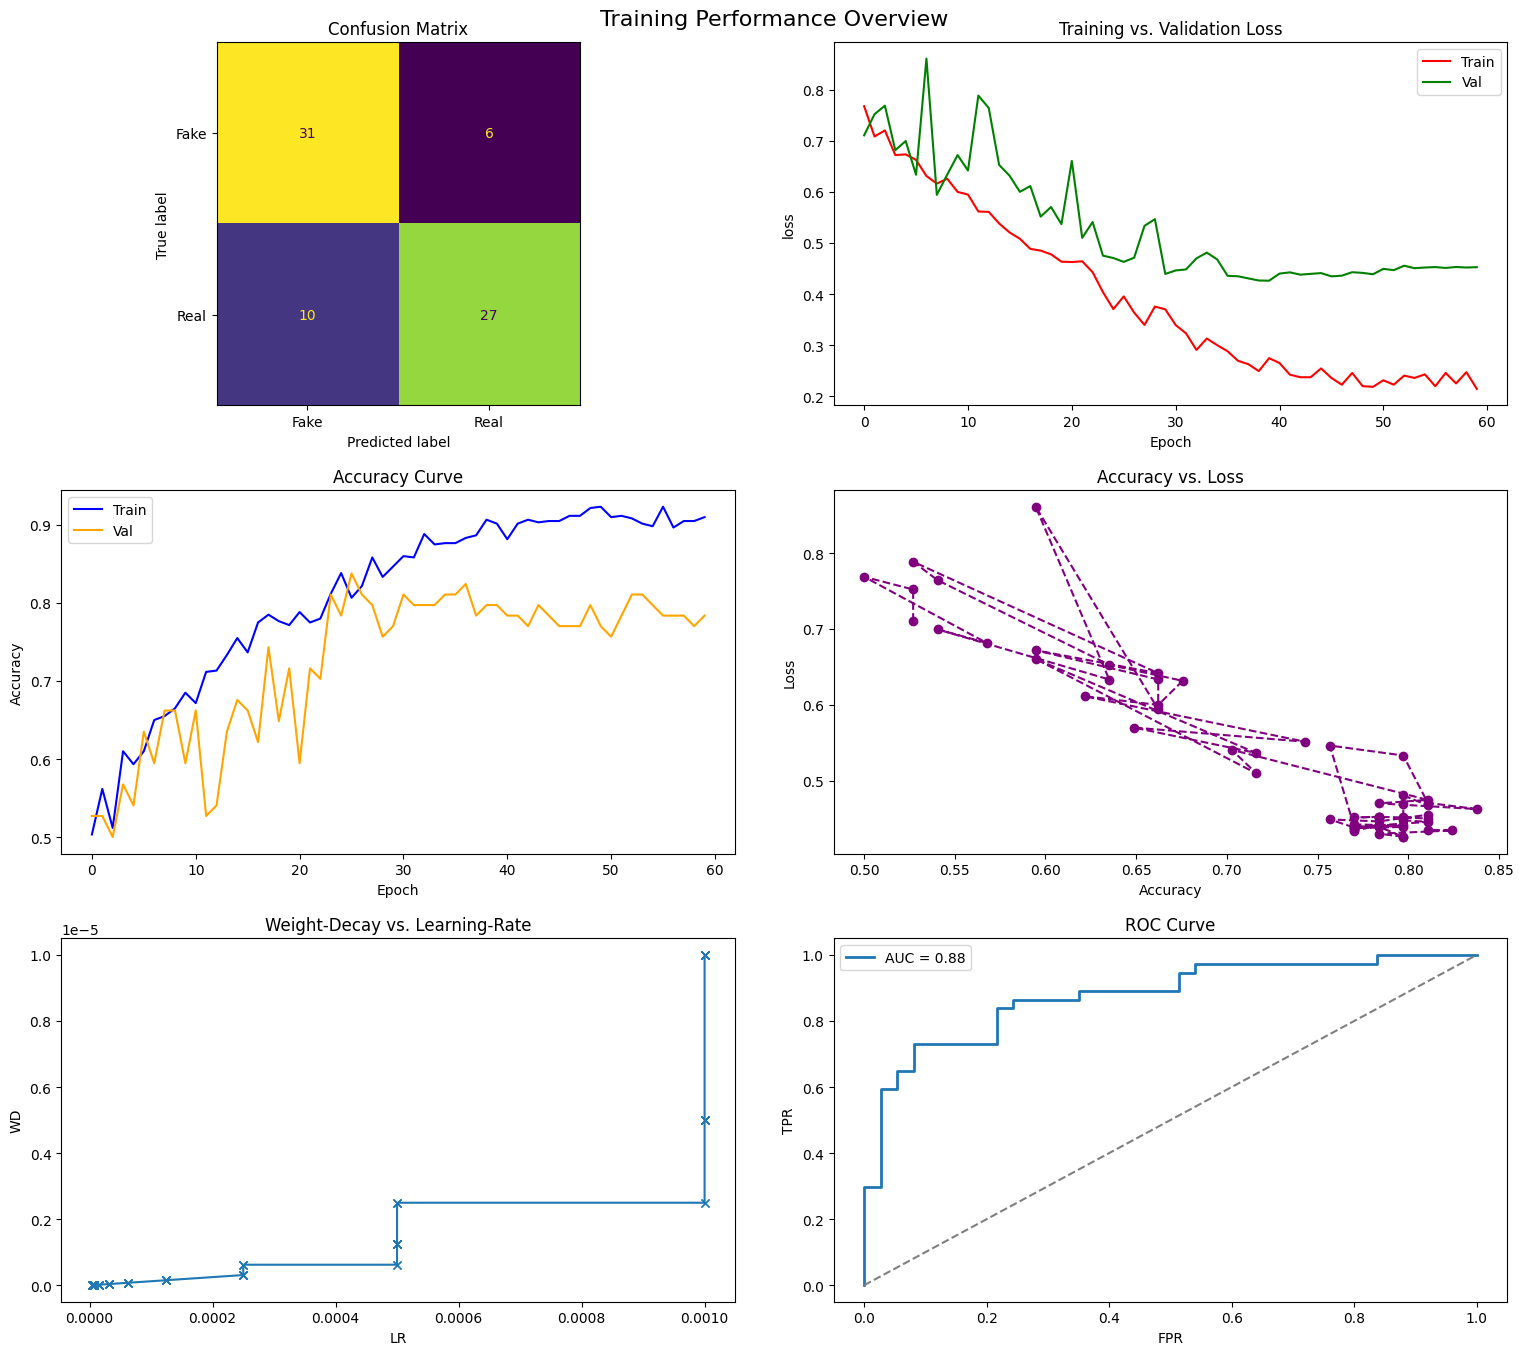

In [16]:
# ── 3DTesr Paths & Launch ──────────────────────────────────────────────────
def collect_video_paths_and_labels(root_dir):
    paths, labels = [], []
    lm = {'real':1, 'fake':0}
    for cls in ['real','fake']:
        cd = os.path.join(root_dir, cls)
        for fn in os.listdir(cd):
            if fn.lower().endswith(('.mp4','.avi','.mov')):
                paths.append(os.path.join(cd, fn))
                labels.append(lm[cls])
    return paths, labels

TRAIN_ROOT = '/content/drive/MyDrive/DL_Project/ff_3D_VID_375v/train'
VALID_ROOT = '/content/drive/MyDrive/DL_Project/ff_3D_VID_375v/validation'

train_videos, train_labels = collect_video_paths_and_labels(TRAIN_ROOT)
val_videos,   val_labels   = collect_video_paths_and_labels(VALID_ROOT)

history, logger, y_true, y_pred, y_prob = meso3D_train_model(
    train_videos,
    train_labels,
    val_videos,
    val_labels,
    batch_size=16,
    epochs   =Epoch_Size,
    model_name   ='meso3d_DeepFake_300Vid_v6_B16_E60_Lr1e-3_Final.weights.h5',
    output_path  ='/content/drive/MyDrive/DL_Project/output/'
)

# Plot performance
plotting_metrics(
    history,
    true_labels     = y_true,
    predictions     = y_pred,
    prediction_prob = y_prob,
    class_names     = ['Fake','Real'],   # 0→Fake, 1→Real
    learning_rate   = logger.lr_history,
    weight_decay    = logger.wd_history
)


In [ ]:
# ── 3DTesr Paths & Launch ──────────────────────────────────────────────────
def collect_video_paths_and_labels(root_dir):
    paths, labels = [], []
    lm = {'real':1, 'fake':0}
    for cls in ['real','fake']:
        cd = os.path.join(root_dir, cls)
        for fn in os.listdir(cd):
            if fn.lower().endswith(('.mp4','.avi','.mov')):
                paths.append(os.path.join(cd, fn))
                labels.append(lm[cls])
    return paths, labels

TRAIN_ROOT = '/content/drive/MyDrive/DL_Project/ff_3D_VID_375v/train'
VALID_ROOT = '/content/drive/MyDrive/DL_Project/ff_3D_VID_375v/validation'

train_videos, train_labels = collect_video_paths_and_labels(TRAIN_ROOT)
val_videos,   val_labels   = collect_video_paths_and_labels(VALID_ROOT)

history, logger, y_true, y_pred, y_prob = meso3D_train_model(
    train_videos,
    train_labels,
    val_videos,
    val_labels,
    batch_size=16,
    epochs   =Epoch_Size,
    model_name   ='meso3d_DeepFake_300Vid_v6_B16_E60_Lr1e-3_Final.weights.h5',
    output_path  ='/content/drive/MyDrive/DL_Project/output/'
)

# Plot performance
plotting_metrics(
    history,
    true_labels     = y_true,
    predictions     = y_pred,
    prediction_prob = y_prob,
    class_names     = ['Fake','Real'],   # 0→Fake, 1→Real
    learning_rate   = logger.lr_history,
    weight_decay    = logger.wd_history
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face detected - Success!

Face extraction report of not_found : 0 ,No missing data - Success!
Face extraction report of no_face : 0 ,At least one face

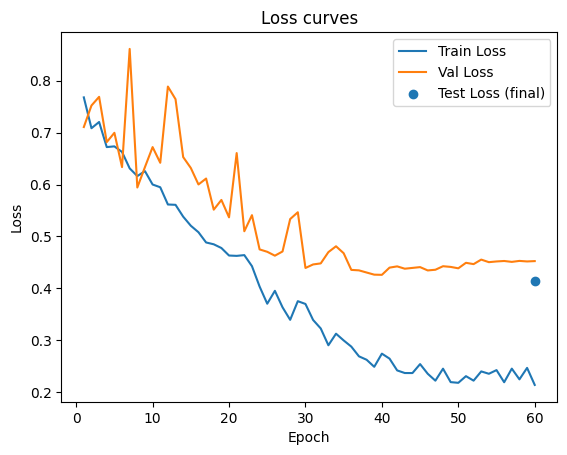

In [17]:
# 1. Collect your test sequence (assuming VideoFaceSequence & FRAME_COUNT etc. are defined)
TEST_ROOT = "/content/drive/MyDrive/DL_Project/ff_3D_VID_375v/test"
test_videos, test_labels = collect_video_paths_and_labels(TEST_ROOT)
test_seq = VideoFaceSequence(test_videos,
                             test_labels,
                             batch_size=16,
                             shuffle=False,
                             verbose=False)

# 2. Load  trained model
model = Meso3D().model
model.load_weights("/content/drive/MyDrive/DL_Project/output/meso3d_DeepFake_300Vid_v6_B16_E60_Lr1e-3_Final.weights.h5")  # or wherever you saved it

# 3. Evaluate on test
test_loss, test_acc = model.evaluate(test_seq, verbose=1)
print(f"🔍 Final test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# 4. Plot train/val loss vs epoch
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"],    label="Train Loss")
plt.plot(epochs, history.history["val_loss"],label="Val Loss")
plt.scatter([epochs[-1]], [test_loss],      label="Test Loss (final)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")
plt.show()


**MesoInception4**

---

In [ ]:
train_path = "/content/drive/MyDrive/DL_Project/deepfake_databaseV2/train"
val_path   = "/content/drive/MyDrive/DL_Project/deepfake_databaseV2/validation"

ckpt_dir = "/content/drive/MyDrive/DL_Project/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

Found 15525 images belonging to 2 classes.
Found 1981 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Starting Epoch 1...
Epoch 1/60
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6102 - loss: 0.8332 
Epoch 1: val_accuracy improved from -inf to 0.42201, saving model to /content/drive/MyDrive/DL_Project/checkpoints/MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5

 Epoch 1 completed in 3595.89 seconds
    Loss: 0.6618 - Accuracy: 0.6663
    Eval Loss: 0.7924 - Eval Accuracy: 0.4220
    Learning Rate: 0.001000 - Decaying weight: 0.000010
243/243 ━━━━━━━━━━━━━━━━━━━━ 3596s 14s/step - accuracy: 0.6104 - loss: 0.8325 - val_accuracy: 0.4220 - val_loss: 0.7924 - learning_rate: 0.0010

Starting Epoch 2...
Epoch 2/60
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7582 - loss: 0.4970
Epoch 2: val_accuracy improved from 0.42201 to 0.70873, saving model to /content/drive/MyDrive/DL_Project/checkpoints/MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5

 Epoch 2 completed in 360.06 seconds
    Loss: 0.4738 - Accuracy: 0.7744
    Eval Loss: 0.4967 - Eval Accuracy: 0.7087
    Learni

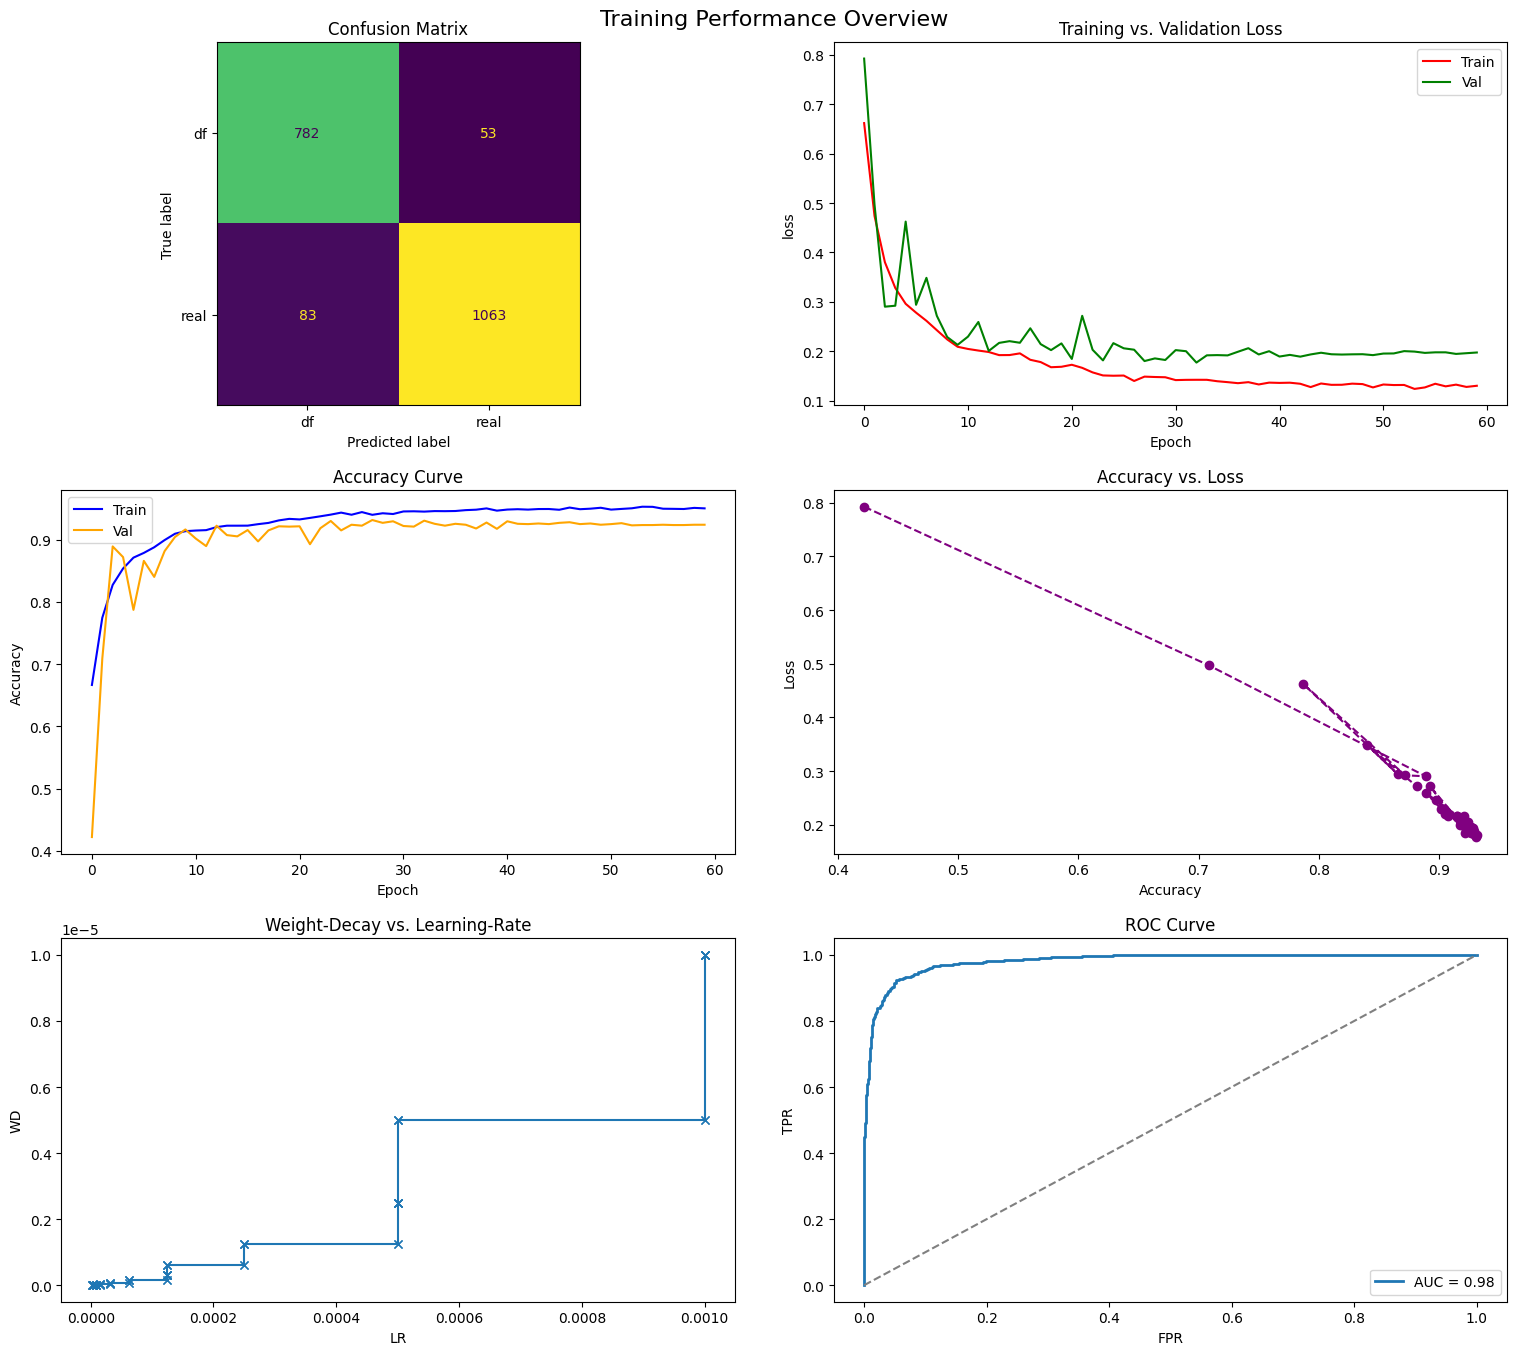


Best epoch = 28 | best val_accuracy = 0.9313


In [ ]:
meso_wrap, hist, logger = train_and_visualize_big(
    ModelClass       = MesoInception4,
    train_dir        = train_path,
    val_dir          = val_path,
    epochs           = Epoch_Size,
    batch_size       = 64,
    lr               = 1e-3,
    use_augmentation = True,
    checkpoint_file  = f"{ckpt_dir}/MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5")

Found 1951 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



✅ FINAL TEST  – loss=0.1714   acc=0.9411


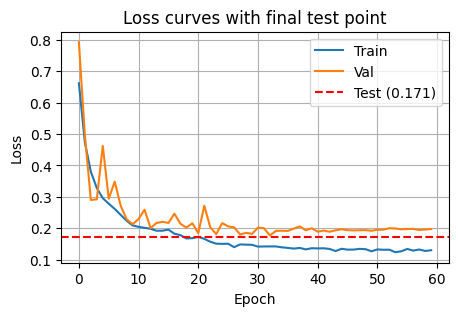

In [ ]:
# ❶  Load the *best* checkpoint selected on val_accuracy
best_h5 = f"{ckpt_dir}/MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5"
meso_wrap.model.load_weights(best_h5)

# ❷  Build a generator for your test-images
test_dir   = "/content/drive/MyDrive/DL_Project/deepfake_databaseV2/test"
test_gen   = ImageDataGenerator(rescale=1./255).flow_from_directory(
                test_dir,
                target_size=(256, 256),
                batch_size=64,
                class_mode='binary',
                shuffle=False)

# ❸  Evaluate and print the metrics
test_loss , test_acc = meso_wrap.model.evaluate(test_gen, verbose=0)
print(f"\n✅ FINAL TEST  – loss={test_loss:.4f}   acc={test_acc:.4f}")

# ❹  (Optional) plot where that test-loss sits on the existing curve
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(hist.history['loss']    , label='Train')
plt.plot(hist.history['val_loss'], label='Val')
plt.axhline(test_loss, c='red', ls='--',
            label=f'Test ({test_loss:.3f})')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss curves with final test point")
plt.legend(); plt.grid(True); plt.show()

**Meso4**

In [ ]:

meso_wrap, hist, logger = train_and_visualize_big(
    ModelClass       = Meso4,
    train_dir        = train_path,
    val_dir          = val_path,
    epochs           = Epoch_Size,
    batch_size       = 64,
    lr               = 1e-3,
    use_augmentation = True,
    checkpoint_file  = f"{ckpt_dir}/Meso4_v6_LR1e-3_B64_EP60_Final.weights.h5")


In [ ]:
# ❶  Load the *best* checkpoint selected on val_accuracy
best_h5 = f"{ckpt_dir}/Meso4_v6_LR1e-3_B64_EP60_Final.weights.h5"
meso_wrap.model.load_weights(best_h5)

# ❷  Build a generator for your test-images
test_dir   = "/content/drive/MyDrive/DL_Project/deepfake_databaseV2/test"
test_gen   = ImageDataGenerator(rescale=1./255).flow_from_directory(
                test_dir,
                target_size=(256, 256),
                batch_size=64,
                class_mode='binary',
                shuffle=False)

# ❸  Evaluate and print the metrics
test_loss , test_acc = meso_wrap.model.evaluate(test_gen, verbose=0)
print(f"\n✅ FINAL TEST  – loss={test_loss:.4f}   acc={test_acc:.4f}")

# ❹  (Optional) plot where that test-loss sits on the existing curve
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(hist.history['loss']    , label='Train')
plt.plot(hist.history['val_loss'], label='Val')
plt.axhline(test_loss, c='red', ls='--',
            label=f'Test ({test_loss:.3f})')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss curves with final test point")
plt.legend(); plt.grid(True); plt.show()

# Part#7: Testing on other Datasets

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



▶ Meso-4 | weights: Meso4_v5_LR1e-3_B64_EP60.weights.h5
   Testing fake videos → /content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs

Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
Predicting  024_073.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Dealing with video  070_057.mp4
Face extraction warning :  0 - found face in full frame [(108, 317, 219, 206)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
Predicting  070_057.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Dealing with video  082_103.mp4
Face extraction warning :  0 - found face in full frame [(95, 367, 207, 255)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't dete

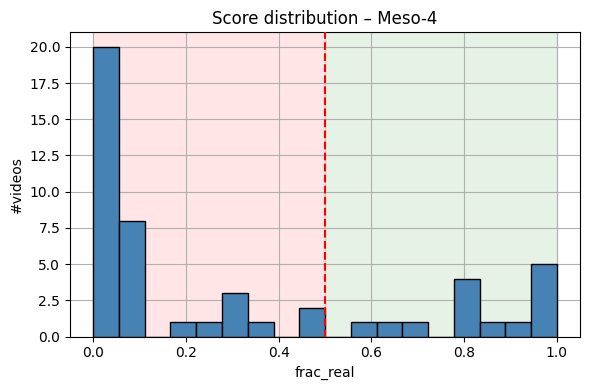

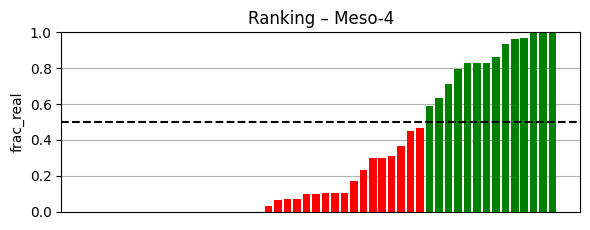

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



▶ Meso-Inception-4 | weights: MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5
   Testing fake videos → /content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs

Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
Predicting  024_073.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Dealing with video  070_057.mp4
Face extraction warning :  0 - found face in full frame [(108, 317, 219, 206)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
Predicting  070_057.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Dealing with video  082_103.mp4
Face extraction warning :  0 - found face in full frame [(95, 367, 207, 255)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of n

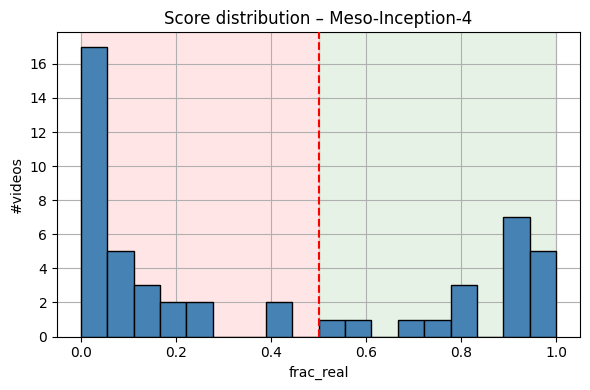

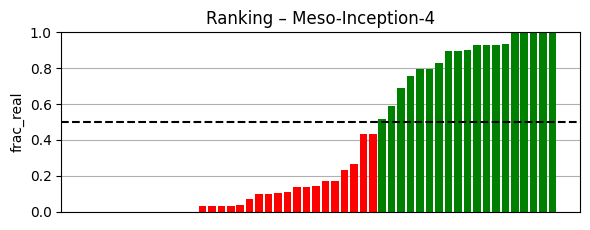


==== Frame‐level quick look ====

--- Meso-4 ---
Face extraction warning :  0 - found face in full frame [(102, 405, 263, 244)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


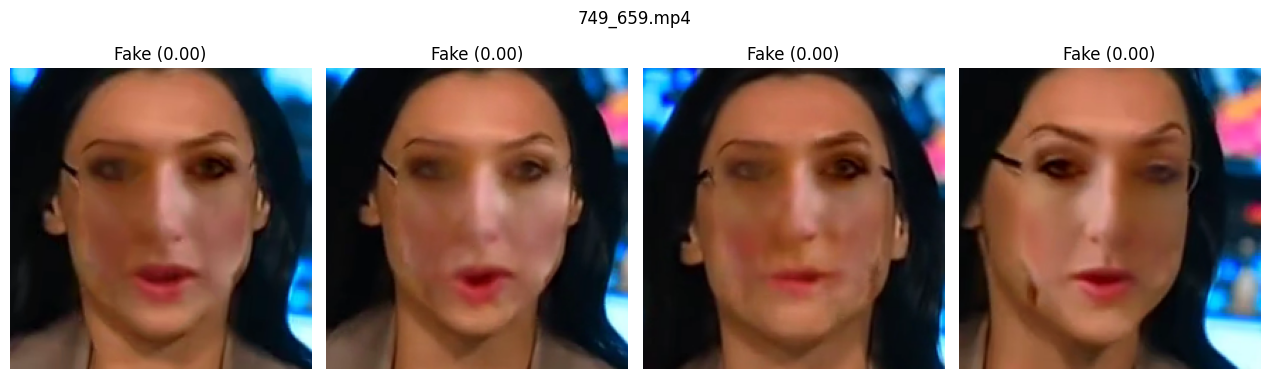

Face extraction warning :  0 - found face in full frame [(178, 1264, 753, 689)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


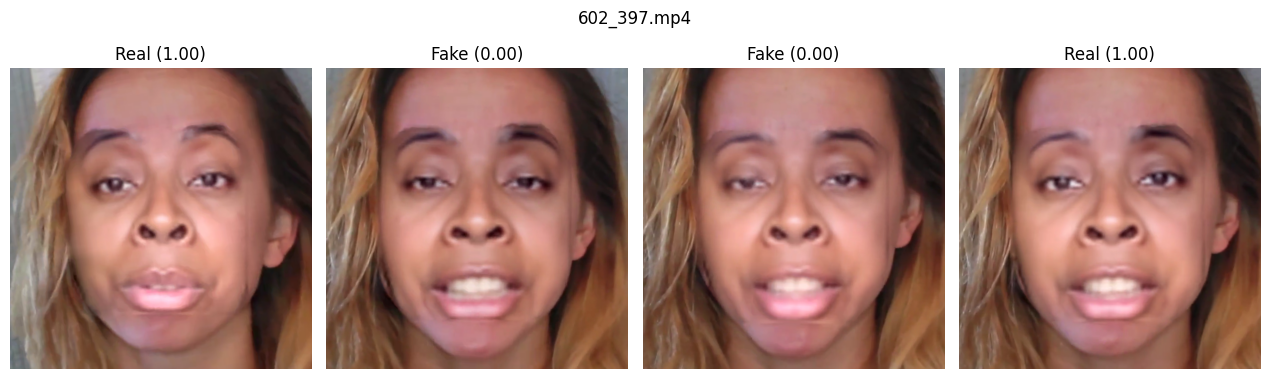

Face extraction warning :  0 - found face in full frame [(102, 904, 263, 743)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


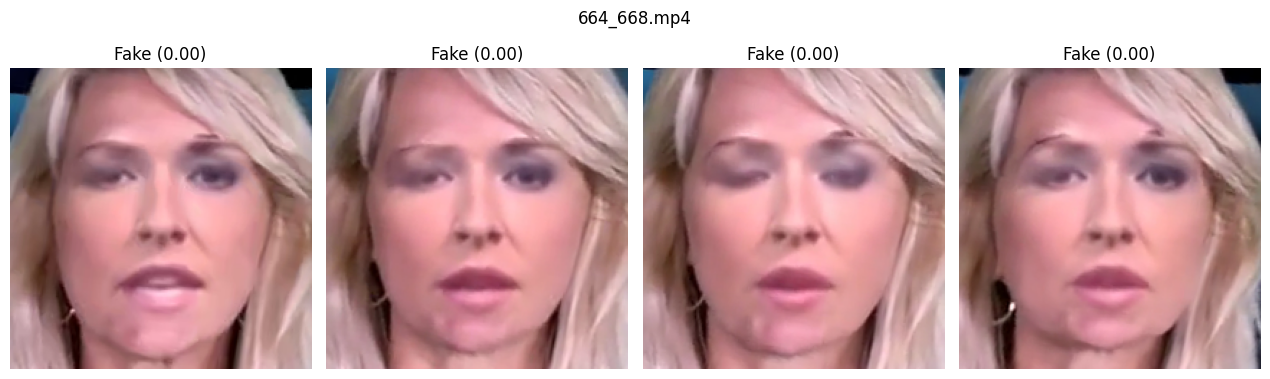

--- Meso-Inception-4 ---
Face extraction warning :  0 - found face in full frame [(102, 405, 263, 244)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


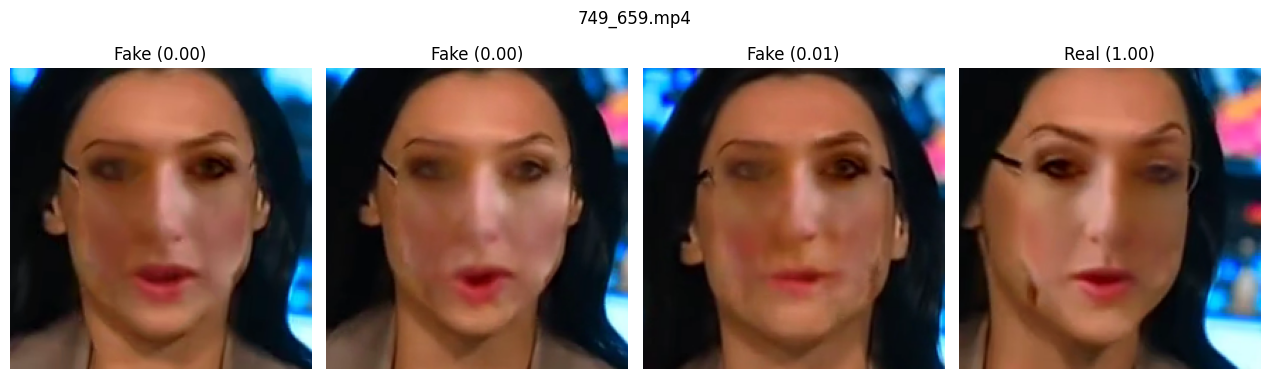

Face extraction warning :  0 - found face in full frame [(178, 1264, 753, 689)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


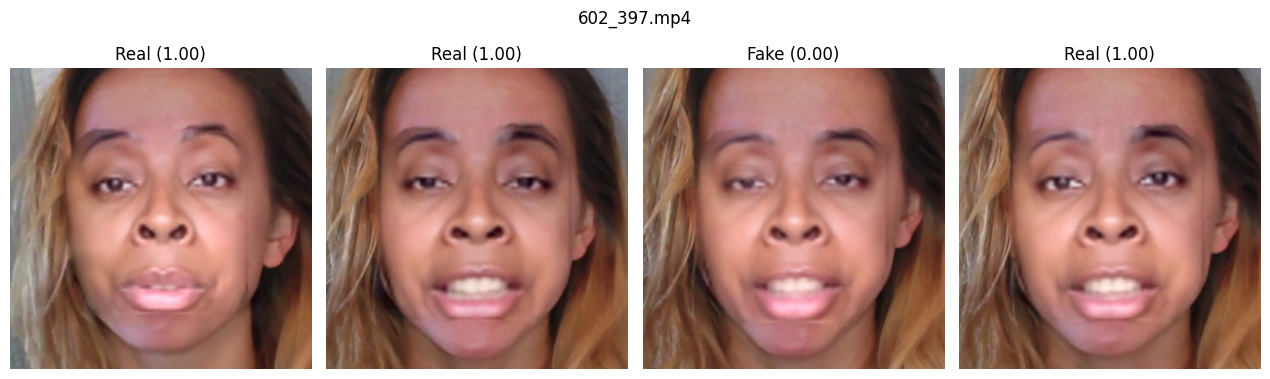

Face extraction warning :  0 - found face in full frame [(102, 904, 263, 743)]
Face extraction report of not_found : 1 ,Some of the data is/are missed!!

Face extraction report of no_face : 0 ,Couldn't detect a face!!
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


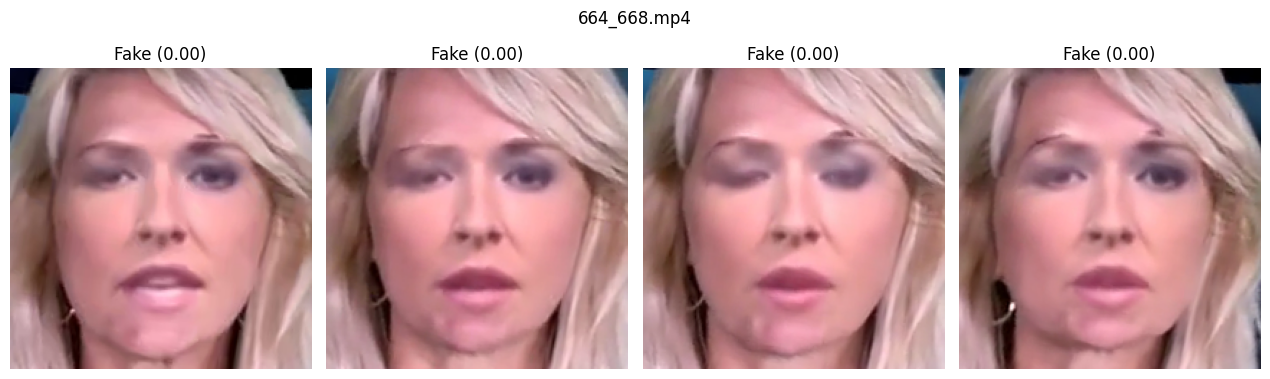


===== OVERALL SUMMARY =====
Model                Fake Detected (%)
-----------------------------------
Meso-4                 72.0
Meso-Inception-4       62.0
-----------------------------------


In [23]:
# deepfake_evaluator_2d_fixed.py

import os, glob, random
import cv2, numpy as np, matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────
# 1 ▸ EDIT THESE PATHS
MY_M4_H5      = "/content/drive/MyDrive/DL_Project/checkpoints/Meso4_v5_LR1e-3_B64_EP60.weights.h5"
MY_MI_H5      = "/content/drive/MyDrive/DL_Project/checkpoints/MesoInception4_v6_LR1e-3_B64_EP60_Final.weights.h5"
TEST_FAKE_DIR = "/content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs"

THRESHOLD = 0.5

# ──────────────────────────────────────────────────────────────
# 2 ▸ unified fake‐only evaluator (2D models only)
def eval_fake_only_2d(net_class, weight_file, fake_dir, thresh=THRESHOLD, title=None):
    net = net_class()
    net.load(weight_file)
    tag = title or net_class.__name__
    print(f"\n▶ {tag} | weights: {os.path.basename(weight_file)}")
    print(f"   Testing fake videos → {fake_dir}\n")

    # author’s 2D pipeline:
    pred    = compute_accuracy(net, fake_dir)
    names   = list(pred.keys())
    scores  = np.array([v[0] for v in pred.values()])
    y_pred  = (scores >= thresh).astype(int)   # 0=fake,1=real
    fake_pct= 100 * np.sum(y_pred==0) / len(scores)

    # print table
    print("video".ljust(25),"│ frac_real │ predicted")
    print("-"*50)
    for v,s,p in zip(names, scores, y_pred):
        lbl = "fake" if p==0 else "real"
        print(v.ljust(25), f"│  {s:8.3f} │", lbl)
    print(f"\nDetected fake videos (<{thresh}): {fake_pct:.1f}%\n")

    return net, scores, fake_pct

# ──────────────────────────────────────────────────────────────
# 3 ▸ plotting helpers with background spans _behind_ the bars
def plot_histogram(title, scores, thresh=THRESHOLD):
    fig, ax = plt.subplots(figsize=(6,4))
    # draw spans first
    ax.axvspan(0, thresh,   alpha=0.1, color='red',   zorder=0)
    ax.axvspan(thresh, 1,   alpha=0.1, color='green', zorder=0)
    # then bars
    ax.hist(scores, bins=18, edgecolor='k', color='steelblue', zorder=2)
    ax.axvline(thresh, color='r', ls='--', zorder=3)
    ax.set_ylim(0, None)
    ax.set_xlabel("frac_real")
    ax.set_ylabel("#videos")
    ax.set_title(f"Score distribution – {title}")
    ax.grid(True, zorder=1)
    plt.tight_layout()
    plt.show()

def plot_ranking(title, scores, thresh=THRESHOLD):
    order  = np.argsort(scores)
    colors = ['green' if s>=thresh else 'red' for s in scores[order]]
    fig, ax = plt.subplots(figsize=(6,2.4))
    ax.bar(range(len(scores)), scores[order], color=colors, zorder=2)
    ax.axhline(thresh, ls='--', c='k', zorder=3)
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_ylabel("frac_real")
    ax.set_title(f"Ranking – {title}")
    ax.grid(axis='y', zorder=1)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# 4 ▸ frame‐level quick look (2D only)
def show_video_frames(vids, classifier, thresh=THRESHOLD, max_frames=4):
    for vid in vids:
        ff = FaceFinder(vid, load_first_face=False)
        ff.find_faces(resize=0.5, skipstep=max(1, ff.length//60))
        idxs = sorted(ff.coordinates.keys())
        if not idxs:
            print(f"[warn] no faces in {os.path.basename(vid)}")
            continue

        step = max(1, len(idxs)//max_frames)
        pick = idxs[::step][:max_frames]

        # batch‐predict with face‐generator
        gen   = FaceBatchGenerator(ff)
        allp  = predict_faces(gen, classifier).flatten()
        preds = [ allp[np.where(np.array(idxs)==i)[0][0]] for i in pick ]

        # plot patches + labels
        fig, axes = plt.subplots(1, len(pick), figsize=(3.2*len(pick),4))
        if len(pick)==1: axes=[axes]
        for ax, idx, p in zip(axes, pick, preds):
            patch = ff.get_aligned_face(idx)
            lbl   = "Real" if p>=thresh else "Fake"
            ax.imshow(patch)
            ax.axis('off')
            ax.set_title(f"{lbl} ({p:.2f})")
        fig.suptitle(os.path.basename(vid))
        plt.tight_layout()
        plt.show()

# ──────────────────────────────────────────────────────────────
# 5 ▸ MAIN – only Meso-4 & Meso-Inception-4 + overall summary
if __name__ == "__main__":
    models = [
        ("Meso-4",           Meso4,            MY_M4_H5),
        ("Meso-Inception-4", MesoInception4,   MY_MI_H5),
    ]

    # store nets & build summary
    results = {}
    summary = []
    for name, cls, w in models:
        net, scores, pct = eval_fake_only_2d(cls, w, TEST_FAKE_DIR, title=name)
        results[name] = net
        summary.append((name, pct))
        plot_histogram(name, scores)
        plot_ranking(name, scores)

    # pick 3 random fakes for quick‐look
    vids = [os.path.join(TEST_FAKE_DIR, f)
            for f in os.listdir(TEST_FAKE_DIR)
            if f.lower().endswith(('.mp4','.avi','.mov'))]
    sample = random.sample(vids, k=min(3,len(vids)))

    print("\n==== Frame‐level quick look ====\n")
    for name in results:
        print(f"--- {name} ---")
        show_video_frames(sample, results[name], thresh=THRESHOLD)

    # overall summary
    print("\n===== OVERALL SUMMARY =====")
    print("Model".ljust(20), "Fake Detected (%)")
    print("-"*35)
    for name, pct in summary:
        print(name.ljust(20), f"{pct:6.1f}")
    print("-"*35)


Found 1951 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



──────── Author weights ────────
Loss = 0.2961 | Acc = 0.8939
Confusion-matrix
 [[ 720   81]
 [ 126 1024]]

Classification-report
               precision    recall  f1-score   support

          df      0.851     0.899     0.874       801
        real      0.927     0.890     0.908      1150

    accuracy                          0.894      1951
   macro avg      0.889     0.895     0.891      1951
weighted avg      0.896     0.894     0.894      1951



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



──────── Fine-tuned ────────
Loss = 0.2075 | Acc = 0.9241
Confusion-matrix
 [[ 715   86]
 [  62 1088]]

Classification-report
               precision    recall  f1-score   support

          df      0.920     0.893     0.906       801
        real      0.927     0.946     0.936      1150

    accuracy                          0.924      1951
   macro avg      0.923     0.919     0.921      1951
weighted avg      0.924     0.924     0.924      1951


========  BENCHMARK SUMMARY  ========
model           |  loss |  acc 
-------------------------------
Author weights  | 0.296 | 0.894
Fine-tuned      | 0.207 | 0.924


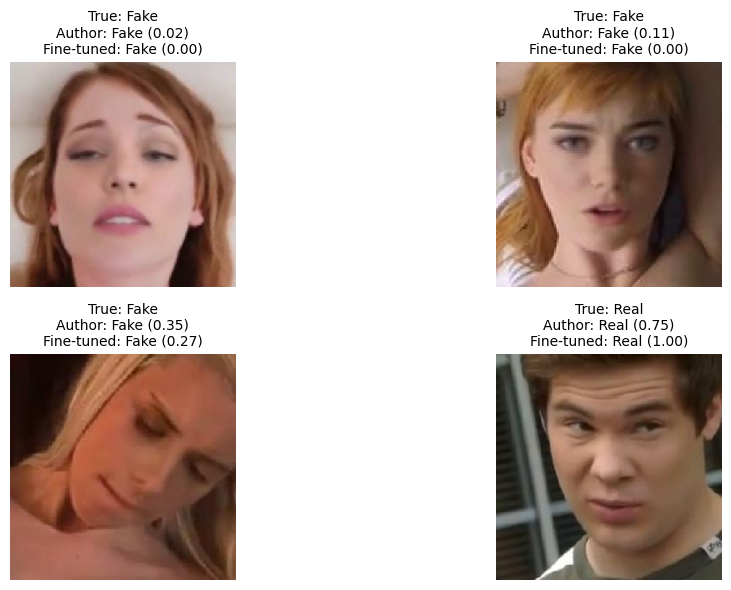

In [22]:
# -*- coding: utf-8 -*-
"""
Benchmark Meso4 (author vs. fine-tuned) on the image-level test set
and visualise 4 widely-spaced samples.

Assumes:
• Meso4 class is already defined / imported in the session.
• TensorFlow + sklearn + matplotlib installed.
"""

# ──────────────────────────────────────────────────────────────
# 0 ▸  imports & paths
# ──────────────────────────────────────────────────────────────
import os, random, math, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

#  adjust these three paths ↓↓↓
TEST_DIR   = "/content/drive/MyDrive/DL_Project/deepfake_databaseV2/test"
ORIG_H5    = "/content/drive/MyDrive/DL_Project/Meso4_DF.h5"          # author’s
MY_H5      = "/content/drive/MyDrive/DL_Project/checkpoints/Meso4_v5_LR1e-3_B64_EP60.weights.h5"

IMG_SIZE   = (256, 256)
BATCH_SIZE = 64
THRESH     = 0.50                              # decision threshold

# ──────────────────────────────────────────────────────────────
# 1 ▸  generator (same instance reused for both evaluations)
# ──────────────────────────────────────────────────────────────
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
              TEST_DIR,
              target_size=IMG_SIZE,
              batch_size=BATCH_SIZE,
              class_mode='binary',
              shuffle=False)

class_map   = {v: k for k, v in test_gen.class_indices.items()}   # {0:'fake', 1:'real'} etc.
class_names = [class_map[0], class_map[1]]

# ──────────────────────────────────────────────────────────────
# 2 ▸  helper to evaluate one weight-file
# ──────────────────────────────────────────────────────────────
def eval_model(weight_file: str, tag: str):
    """Returns dict with loss / acc; prints full metrics."""
    net = Meso4();  net.load(weight_file)

    loss, acc = net.model.evaluate(test_gen, verbose=0)

    probs = net.model.predict(test_gen, verbose=0).ravel()
    preds = (probs >= THRESH).astype(int)
    y_true = test_gen.classes

    cm  = confusion_matrix(y_true, preds)
    rep = classification_report(y_true, preds,
                                target_names=class_names, digits=3)

    print(f"\n──────── {tag} ────────")
    print(f"Loss = {loss:.4f} | Acc = {acc:.4f}")
    print("Confusion-matrix\n", cm)
    print("\nClassification-report\n", rep)

    return dict(tag=tag, loss=loss, acc=acc, net=net)   # keep net for later

# ──────────────────────────────────────────────────────────────
# 3 ▸  run the two evaluations
# ──────────────────────────────────────────────────────────────
res_orig = eval_model(ORIG_H5, "Author weights")
res_fine = eval_model(MY_H5  , "Fine-tuned")

print("\n========  BENCHMARK SUMMARY  ========")
print("model".ljust(15),"|  loss |  acc ")
print("-"*31)
for r in (res_orig, res_fine):
    print(r['tag'].ljust(15), f"| {r['loss']:.3f} | {r['acc']:.3f}")

# ──────────────────────────────────────────────────────────────
# 4 ▸  choose 4 *far-apart* images and visualise predictions
# ──────────────────────────────────────────────────────────────
random.seed(0)

all_paths = test_gen.filepaths              # ordered file list
n_imgs    = len(all_paths)
if n_imgs < 4:
    raise ValueError("Need ≥4 test images, found", n_imgs)

# pick indices spaced ≥ n_imgs/8 apart
gap       = max(1, n_imgs // 8)
offset    = random.randint(0, gap-1)
idxs      = sorted((offset + i*gap) % n_imgs for i in range(4))

# load those 4 images manually
X_vis, y_vis = [], []
for ix in idxs:
    img = tf.keras.utils.load_img(all_paths[ix], target_size=IMG_SIZE)
    arr = tf.keras.utils.img_to_array(img) / 255.0
    X_vis.append(arr)
    y_vis.append(test_gen.classes[ix])
X_vis = np.stack(X_vis, axis=0);  y_vis = np.array(y_vis)

# predictions from both models on these 4 images
prob_o = res_orig['net'].model.predict(X_vis, verbose=0).ravel()
prob_f = res_fine['net'].model.predict(X_vis, verbose=0).ravel()

plt.figure(figsize=(12,6))
for i in range(4):
    true_lab = "Real" if y_vis[i] == 1 else "Fake"

    p_o, p_f = prob_o[i], prob_f[i]
    lab_o = "Real" if p_o >= THRESH else "Fake"
    lab_f = "Real" if p_f >= THRESH else "Fake"

    title = (f"True: {true_lab}\n"
             f"Author: {lab_o} ({p_o:.2f})\n"
             f"Fine-tuned: {lab_f} ({p_f:.2f})")

    plt.subplot(2, 2, i+1)
    plt.imshow(X_vis[i]); plt.axis('off')
    plt.title(title, fontsize=10)

plt.tight_layout(); plt.show()
